In [5]:
#requirements install

!pip install torch==2.2.1
!pip install torchvision==0.17.1
!pip install matplotlib
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

CUDA is not available. Running on CPU.
Epoch 0/24
----------
train Loss: 0.5176 Acc: 0.7768
val Loss: 0.4740 Acc: 0.6875
Epoch 1/24
----------
train Loss: 0.4176 Acc: 0.8156
val Loss: 1.0205 Acc: 0.5000
Epoch 2/24
----------
train Loss: 0.3697 Acc: 0.8461
val Loss: 0.9938 Acc: 0.6250
Epoch 3/24
----------
train Loss: 0.3465 Acc: 0.8585
val Loss: 0.5283 Acc: 0.7500
Epoch 4/24
----------
train Loss: 0.3164 Acc: 0.8692
val Loss: 1.0638 Acc: 0.6250
Epoch 5/24
----------
train Loss: 0.3170 Acc: 0.8679
val Loss: 0.9665 Acc: 0.6250
Epoch 6/24
----------
train Loss: 0.2983 Acc: 0.8777
val Loss: 0.8549 Acc: 0.6875
Epoch 7/24
----------
train Loss: 0.2272 Acc: 0.9055
val Loss: 0.8457 Acc: 0.6875
Epoch 8/24
----------
train Loss: 0.2300 Acc: 0.9084
val Loss: 0.9238 Acc: 0.6875
Epoch 9/24
----------
train Loss: 0.2348 Acc: 0.9053
val Loss: 0.9743 Acc: 0.6875
Epoch 10/24
----------
train Loss: 0.2269 Acc: 0.9132
val Loss: 0.7985 Acc: 0.6875
Epoch 11/24
----------
train Loss: 0.2183 Acc: 0.9101
val 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Accuracy of the network on the test images: 89.1025641025641%
Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.74      0.83       234
   Pneumonia       0.86      0.98      0.92       390

    accuracy                           0.89       624
   macro avg       0.91      0.86      0.88       624
weighted avg       0.90      0.89      0.89       624



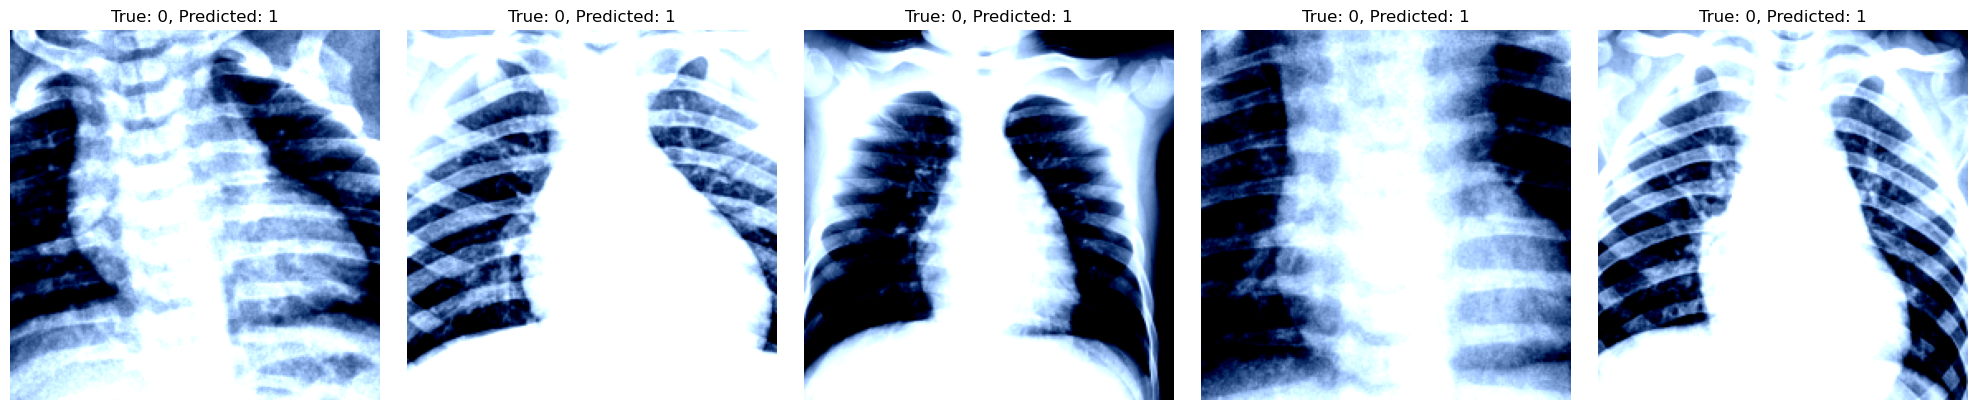

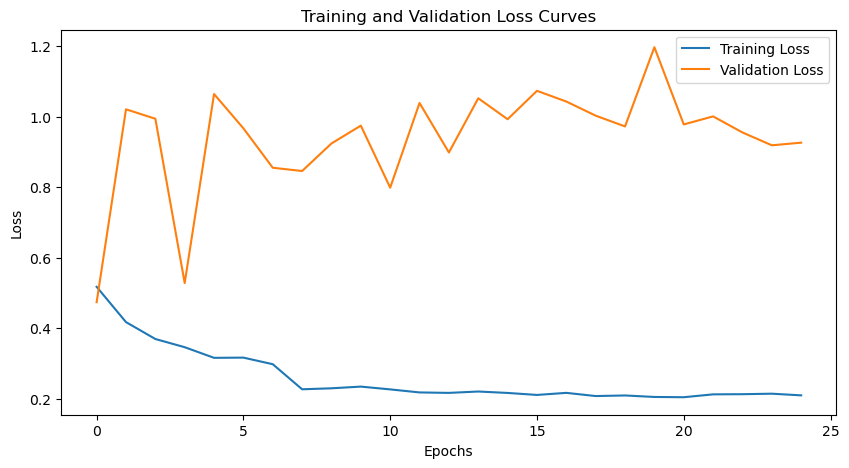

In [6]:
#task_1.1

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torchvision.models import resnet18, ResNet18_Weights
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# CUDA availability
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Running on GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Running on CPU.")

data_dir = "/Users/saurabhagarwal/Downloads/datasets/chest_xray"

# data augmentation for the training set
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# transformations for validation and testing sets
val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), train_transform),
    'val': datasets.ImageFolder(os.path.join(data_dir, 'val'), val_test_transform),
    'test': datasets.ImageFolder(os.path.join(data_dir, 'test'), val_test_transform)
}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}

def initialize_model(model_name, num_classes, use_pretrained=True):
    model = None

    if model_name == "resnet18":
        if use_pretrained:
            weights = ResNet18_Weights.DEFAULT
            model = resnet18(weights=weights)
        else:
            model = resnet18(weights=None)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)

    return model

model = initialize_model("resnet18", 2, use_pretrained=False)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# train model
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
                scheduler.step()
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)

    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history

model_ft, train_loss_history, val_loss_history, train_acc_history, val_acc_history = train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25)

# test model
def test_model(model, dataloaders, phase='test', num_failure_cases=5):
    model.eval()
    correct = 0
    total = 0
    true_labels = []
    predicted_labels = []
    misclassified_images = []
    misclassified_true_labels = []
    misclassified_predicted_labels = []

    with torch.no_grad():
        for data in dataloaders[phase]:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

            misclassified_mask = (predicted != labels)
            misclassified_images.extend(images[misclassified_mask].cpu())
            misclassified_true_labels.extend(labels[misclassified_mask].cpu().numpy())
            misclassified_predicted_labels.extend(predicted[misclassified_mask].cpu().numpy())

    print(f'Accuracy of the network on the test images: {100 * correct / total}%')
    print('Classification Report:')
    print(classification_report(true_labels, predicted_labels, target_names=['Normal', 'Pneumonia']))

    # Display misclassified images
    fig, axes = plt.subplots(nrows=1, ncols=num_failure_cases, figsize=(20, 4))
    for i in range(num_failure_cases):
        if i >= len(misclassified_images):
            break
        image = misclassified_images[i]
        true_label = misclassified_true_labels[i]
        predicted_label = misclassified_predicted_labels[i]
        axes[i].imshow(image.permute(1, 2, 0).numpy())
        axes[i].set_title(f"True: {true_label}, Predicted: {predicted_label}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

test_model(model, dataloaders)


# plotting
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

Epoch 0/24
----------
train Loss: 0.4133 Acc: 0.8303
val Loss: 0.5234 Acc: 0.6875
Epoch 1/24
----------
train Loss: 0.3145 Acc: 0.8765
val Loss: 1.1906 Acc: 0.6250
Epoch 2/24
----------
train Loss: 0.2614 Acc: 0.9049
val Loss: 0.2784 Acc: 0.8125
Epoch 3/24
----------
train Loss: 0.2446 Acc: 0.9082
val Loss: 1.1239 Acc: 0.5625
Epoch 4/24
----------
train Loss: 0.2425 Acc: 0.9122
val Loss: 0.4919 Acc: 0.5625
Epoch 5/24
----------
train Loss: 0.2194 Acc: 0.9218
val Loss: 0.6038 Acc: 0.7500
Epoch 6/24
----------
train Loss: 0.2000 Acc: 0.9289
val Loss: 0.3080 Acc: 0.8125
Epoch 7/24
----------
train Loss: 0.1454 Acc: 0.9484
val Loss: 0.3681 Acc: 0.8125
Epoch 8/24
----------
train Loss: 0.1448 Acc: 0.9521
val Loss: 0.3677 Acc: 0.8125
Epoch 9/24
----------
train Loss: 0.1373 Acc: 0.9536
val Loss: 0.4478 Acc: 0.7500
Epoch 10/24
----------
train Loss: 0.1446 Acc: 0.9467
val Loss: 0.4842 Acc: 0.6875
Epoch 11/24
----------
train Loss: 0.1425 Acc: 0.9540
val Loss: 0.3894 Acc: 0.8125
Epoch 12/24
--

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Accuracy of the network on the test images: 88.14102564102564%
Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      0.69      0.81       234
   Pneumonia       0.84      1.00      0.91       390

    accuracy                           0.88       624
   macro avg       0.92      0.84      0.86       624
weighted avg       0.90      0.88      0.88       624



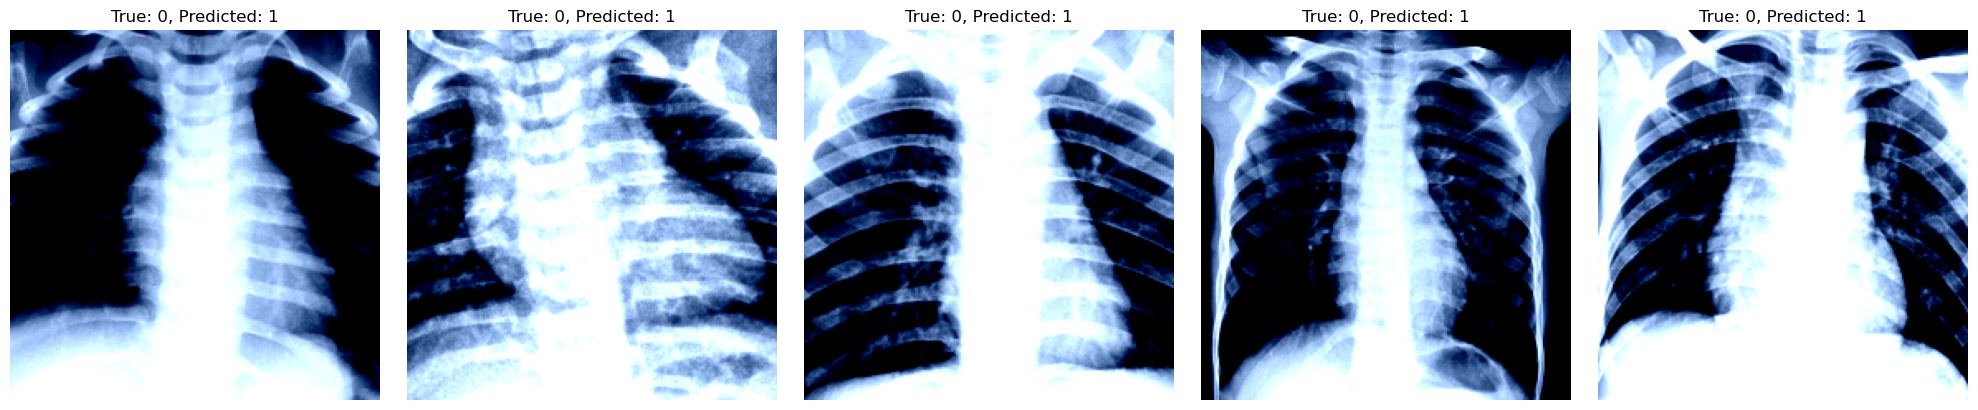

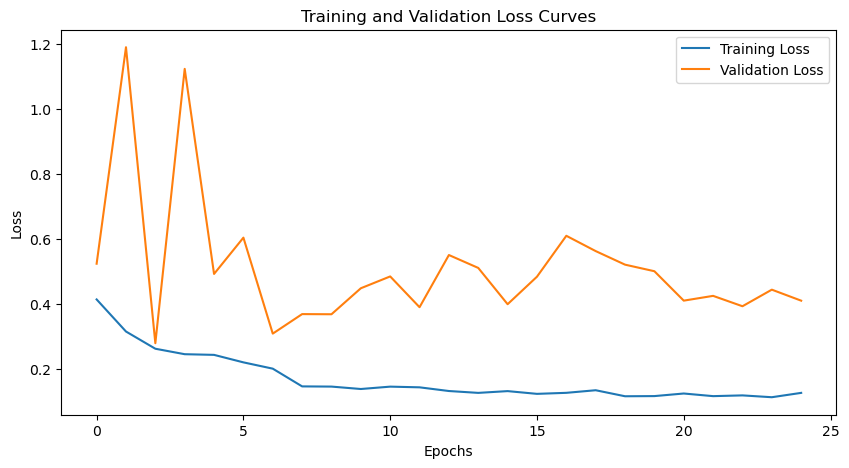

In [7]:
#task_1.2


# data augmentation for the training set
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# transformations for validation and testing sets
val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), train_transform),
    'val': datasets.ImageFolder(os.path.join(data_dir, 'val'), val_test_transform),
    'test': datasets.ImageFolder(os.path.join(data_dir, 'test'), val_test_transform)
}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}

def initialize_model(model_name, num_classes, use_pretrained=True):
    model = None

    if model_name == "resnet18":
        if use_pretrained:
            weights = ResNet18_Weights.DEFAULT
            model = resnet18(weights=weights)
        else:
            model = resnet18(weights=None)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)

    return model

model = initialize_model("resnet18", 2, use_pretrained=True)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)


scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# train model
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
                scheduler.step()
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)

    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history

model_ft, train_loss_history, val_loss_history, train_acc_history, val_acc_history = train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25)

#test model
def test_model(model, dataloaders, phase='test', num_failure_cases=5):
    model.eval()
    correct = 0
    total = 0
    true_labels = []
    predicted_labels = []
    misclassified_images = []
    misclassified_true_labels = []
    misclassified_predicted_labels = []

    with torch.no_grad():
        for data in dataloaders[phase]:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

            misclassified_mask = (predicted != labels)
            misclassified_images.extend(images[misclassified_mask].cpu())
            misclassified_true_labels.extend(labels[misclassified_mask].cpu().numpy())
            misclassified_predicted_labels.extend(predicted[misclassified_mask].cpu().numpy())

    print(f'Accuracy of the network on the test images: {100 * correct / total}%')
    print('Classification Report:')
    print(classification_report(true_labels, predicted_labels, target_names=['Normal', 'Pneumonia']))

    # Display misclassified images
    fig, axes = plt.subplots(nrows=1, ncols=num_failure_cases, figsize=(20, 4))
    for i in range(num_failure_cases):
        if i >= len(misclassified_images):
            break
        image = misclassified_images[i]
        true_label = misclassified_true_labels[i]
        predicted_label = misclassified_predicted_labels[i]
        axes[i].imshow(image.permute(1, 2, 0).numpy())
        axes[i].set_title(f"True: {true_label}, Predicted: {predicted_label}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

test_model(model, dataloaders)

# plotting
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()